## Problem Description

Given the tabular data containing 52 features, we have to predict the "SalePrice" in the validation dataset.

## Dataset

Dataset can be downloaded from here [Predict Future Sales](https://www.kaggle.com/c/bluebook-for-bulldozers/data)

## Approach and accuracy achieved

Since the dataset contained a good amount of features and considerable amount of values in dataset were null, I thought to select limited number of features based on feature importance. For this I trained a Random forest baseline model and got the importance score of all the features. According to this score features for the final model were selected and Random Forest and lightgbm were tried on the dataset.

Based on importance score I have also tried to replace the null values of the 2 most important features (after age) that were "Coupler_System" and "ProductSize" but the results were not improved.

### Accuracy

Evaluation parameter: RMSLE (Root mean squared log error) <br>
Random Forest: 0.2467792326875891 (using all features) <br>
Random Forest: 0.24603803475291686 (using selected features) <br>
lightgbm: 0.246417 (using features after calculating importance scores) <br>
<br>
We can't submit to the competition now, but the score achieved would have put us in top 40-50 of the competition

## Imports

In [ ]:
import pandas as pd
import re
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import numpy as np
import math
from sklearn import metrics
from pandas.api.types import is_string_dtype, is_numeric_dtype
import matplotlib.pyplot as plt 
from sklearn.ensemble import forest

## Loading the dataset

In [46]:
df_train = pd.read_csv('Train/Train.csv', low_memory=False, parse_dates=['saledate'])
df_valid = pd.read_csv('Valid/Valid.csv', low_memory=False, parse_dates=['saledate'])

In [47]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
        


## A look at first 5 rows

In [40]:
print('training',df_train.shape)
print('validation', df_valid.shape)
display_all(df_train.head().T)


training (397605, 66)
validation (11573, 52)


,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,11.0974,10.9508,9.21034,10.5584,9.30565
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,2,2,0,0,1
fiModelDesc,521D,950FII,226,PC120-6E,S175


## Important info about train set

In [26]:
display_all(df_train.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaT,NaT,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaT,NaT,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaT,NaT,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaT,NaT,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaT,NaT,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaT,NaT,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaT,NaT,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaT,NaT,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17,2011-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Percentage of null values for every column

There are ton of null values in dataset let's have a look at them

In [27]:

display_all(df_train.isnull().sum().sort_index()/len(df_train))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

## Correlation Matrix ( It don't cover all features as most of the features have datatype object , so we have used feature importance from baseline models for better results)

SalesID                     0.010725
SalePrice                   1.000000
MachineID                  -0.224854
ModelID                    -0.042125
datasource                  0.015122
auctioneerID               -0.046865
YearMade                    0.156453
MachineHoursCurrentMeter    0.013560
dtype: float64


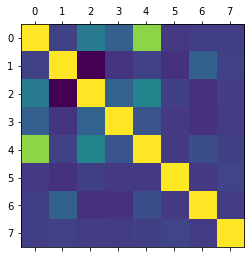

In [48]:
import seaborn as sns
print(df_train.corrwith(df_train['SalePrice'])) 
plt.matshow(df_train.corr())
plt.show()



## Getting important info about validation dataset


In [28]:
display_all(df_valid.describe(include='all').T)


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,11573,NaN,NaN,NaN,NaT,NaT,5.18081e+06,1.61944e+06,1.22284e+06,4.31262e+06,6.26485e+06,6.28634e+06,6.33335e+06
MachineID,11573,NaN,NaN,NaN,NaT,NaT,1.65149e+06,652249,150,1.0673e+06,1.86215e+06,2.27053e+06,2.48525e+06
ModelID,11573,NaN,NaN,NaN,NaT,NaT,8940.14,7807.39,28,3362,4763,14303,37197
datasource,11573,NaN,NaN,NaN,NaT,NaT,152.623,14.8721,121,149,149,172,173
auctioneerID,11573,NaN,NaN,NaN,NaT,NaT,7.54748,22.3071,0,1,1,3,99
YearMade,11573,NaN,NaN,NaN,NaT,NaT,1895.33,305.482,1000,1993,2001,2005,2014
MachineHoursCurrentMeter,4739,NaN,NaN,NaN,NaT,NaT,5482.14,6391.1,0,1268,3786,7793,89200
UsageBand,4031,3,Medium,1847,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,11573,94,2012-02-13 00:00:00,1598,2012-01-01,2012-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fiModelDesc,11573,1731,310G,309,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Percentage of null value for every column in train and valid dataset

In [29]:
print(display_all(df_valid.isnull().sum().sort_index()/len(df_valid)),display_all(df_train.isnull().sum().sort_index()/len(df_train)))

Backhoe_Mounting            0.823728
Blade_Extension             0.933984
Blade_Type                  0.823555
Blade_Width                 0.933984
Coupler                     0.418733
Coupler_System              0.869005
Differential_Type           0.813964
Drive_System                0.764452
Enclosure                   0.000778
Enclosure_Type              0.933984
Engine_Horsepower           0.933984
Forks                       0.512832
Grouser_Tracks              0.869265
Grouser_Type                0.737320
Hydraulics                  0.173680
Hydraulics_Flow             0.869265
MachineHoursCurrentMeter    0.590512
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.830467
Pattern_Changer             0.737060
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.503759
Pushblock                   0.933984
Ride_Control                0.643826
Ripper                      0.757366
S

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

None None


### Both train and valid dataset have same columns with zero null values and percentage of null values in every columns are comparable

In [30]:
## Looking for outliers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f576b901240>]],
      dtype=object)

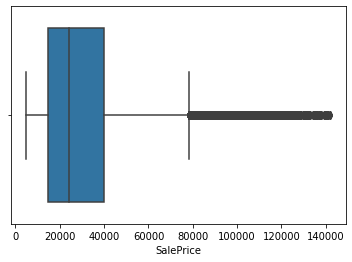

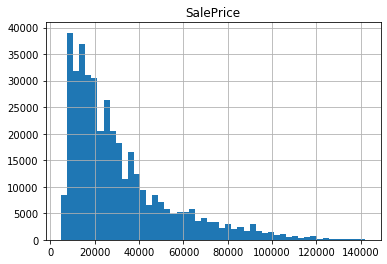

In [31]:

import seaborn as sns
sns.boxplot(x=df_train['SalePrice'])

df_train.hist(column='SalePrice',bins=50)



### By looking at data we will remove the rows with SalePrice>110000

2846
(397605, 53)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f576b8d5748>]],
      dtype=object)

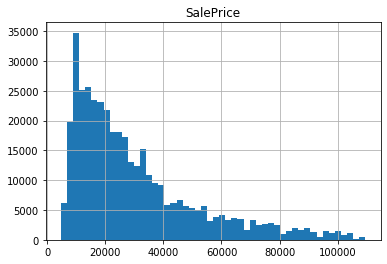

In [32]:
print ((df_train.SalePrice[df_train.SalePrice > 110000]).count())
df_train = df_train[df_train['SalePrice'] < 110000]
print (df_train.shape)

df_train.hist(column='SalePrice',bins=50)

In [33]:
## Converting Sale Price to log scale as evaluation parameter is RMLE
df_train.SalePrice = np.log(df_train.SalePrice)

## Create new Features

In [34]:
def add_datepart(df, fldname, drop=True, time=False):
    '''Making more features from the dates features in the Dataset'''
    
    fld = df[fldname]
    fld_dtype = fld.dtype
    
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time:
        attr = attr + ['Hour', 'Minute', 'Second']
        
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    
    if drop: df.drop(fldname, axis=1, inplace=True)
        
add_datepart(df_train, 'saledate')

# Creating a new feature named age that is age of the Bulldozer at the time of the sale
df_train['age'] = df_train['saleYear'] - df_train['YearMade']

In [35]:
print(df_train.shape)
print(df_train.UsageBand.head().T)

(397605, 66)
0       Low
1       Low
2      High
3      High
4    Medium
Name: UsageBand, dtype: object


## convert string features to categorical


In [36]:
for n,c in df_train.items():
    if is_string_dtype(c): 
        df_train[n] = c.astype('category').cat.as_ordered()
        
#Specify order for variable UsageBand and change to codes
df_train.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
df_train.UsageBand = df_train.UsageBand.cat.codes



In [41]:
df_train.UsageBand.describe()

count    397605.000000
mean         -0.624680
std           0.869971
min          -1.000000
25%          -1.000000
50%          -1.000000
75%          -1.000000
max           2.000000
Name: UsageBand, dtype: float64

In [42]:
'''
For continuous variables, it checks whether a column has missing values or not
If the column has missing values, it creates another column called columnname_na, which has 1 for missing and 0 for not missing
Simultaneously, the missing values are replaced with the median of the column
For categorical variables, pandas replaces missing values with -1. So proc_df adds 1 to all the values for categorical variables. Thus, we have 0 for missing while all other values are incremented by 1'''

def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict


def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1


def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

df, y, nas = proc_df(df_train, 'SalePrice')

In [43]:
#Split the dataset into training and validation sets. Use 12,000 as the validation set for our baseline model
def split_vals(a,n): 
    return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_train, n_trn) #for using unprocessed data if needed.

X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((385605, 67), (12000, 67), (385605,), (12000,))

## Run base model

In [44]:

def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    
m = RandomForestRegressor(n_jobs=-1,oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07589526035168312, 0.2320971580371068, 0.987481263438796, 0.900892434126608, 0.909077140856287]


In [45]:

feature_importance = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : m.feature_importances_})
feature_importance.sort_values('Importance', ascending=False, inplace=True)
feature_importance.head(30)

,Feature,Importance
37,Coupler_System,0.202020
64,age,0.163761
13,ProductSize,0.143692
14,fiProductClassDesc,0.130239
2,ModelID,0.076002
5,YearMade,0.053342
10,fiSecondaryDesc,0.030270
63,saleElapsed,0.027277
8,fiModelDesc,0.025172
0,SalesID,0.020822


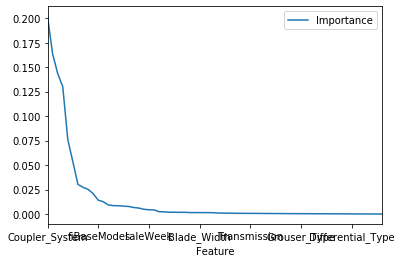

In [46]:
feature_importance.plot('Feature', 'Importance')

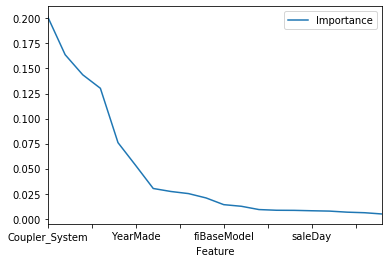

In [47]:
feature_importance.head(20).plot('Feature', 'Importance')

## Searching for right set of features

In [48]:
for i in [0.0001, 0.0005, 0.0007, 0.0008, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.011, 0.012]:
    important_features = feature_importance[feature_importance['Importance'] > i]
    df_important = df[important_features['Feature']]
    X_train, X_valid = split_vals(df_important, n_trn)
    y_train, y_valid = split_vals(y, n_trn)

    m = RandomForestRegressor(n_estimators=40, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print_score(m)

[0.07690140500924135, 0.22721143692123688, 0.9871471411159466, 0.905021011327923, 0.9082164758523077]
[0.07685284850763792, 0.22706179404469237, 0.9871633669009994, 0.9051460776441843, 0.9083639319201385]
[0.07696958976052724, 0.22649701529492944, 0.9871243389967086, 0.9056173577623994, 0.9079830492841625]
[0.07686803295318693, 0.22785759246824625, 0.9871582939228133, 0.9044800309398097, 0.9083864547977911]
[0.07703437686598869, 0.22504217116228614, 0.9871026543837863, 0.9068259479877558, 0.9079032598766281]
[0.07731399472195734, 0.22561540429051394, 0.9870088553977986, 0.9063506728225781, 0.9070332940032941]
[0.07760370301257372, 0.224392143235587, 0.9869113130627103, 0.9073634318232029, 0.9064545462891802]
[0.07760288690673282, 0.22493289576951994, 0.9869115883510607, 0.9069164124468541, 0.9066306915389083]
[0.07782835374553022, 0.2245456401569377, 0.9868354239239954, 0.9072366511680413, 0.906205714643136]
[0.07779298464482617, 0.22453543010645519, 0.9868473864901864, 0.9072450868423

## The best cut off point seems to be 0.008 when the RMSE score is 0.22188114936630077

In [49]:

important_features = feature_importance[feature_importance['Importance'] > 0.008]

print (len(important_features))
print (important_features)

df_important = df[important_features['Feature']]
X_train, X_valid = split_vals(df_important, n_trn)
y_train, y_valid = split_vals(y, n_trn)

m = RandomForestRegressor(n_estimators=40, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

16
               Feature  Importance
37      Coupler_System    0.202020
64                 age    0.163761
13         ProductSize    0.143692
14  fiProductClassDesc    0.130239
2              ModelID    0.076002
5             YearMade    0.053342
10     fiSecondaryDesc    0.030270
63         saleElapsed    0.027277
8          fiModelDesc    0.025172
0              SalesID    0.020822
9          fiBaseModel    0.014146
1            MachineID    0.012520
18        Drive_System    0.009241
15               state    0.008546
56       saleDayofyear    0.008450
54             saleDay    0.008048
[0.0785578433045283, 0.2232586810026779, 0.9865874827294375, 0.9082969302854713, 0.9044443926566479]


# Checking different models on training Dataset

In [3]:
df_train=pd.read_csv('Train/Train.csv', low_memory=False, parse_dates=['saledate'])
df_valid = pd.read_csv('Valid/Valid.csv', low_memory=False, parse_dates=['saledate'])

# Some Experiments that didn't work

## Analysing 'ProductSize' against 'SalePrice' to create new features (Didn't work)

training shape (401125, 53)
validation shape (11573, 52)
[nan 'Medium' 'Small' 'Large / Medium' 'Mini' 'Large' 'Compact']
(210775, 53)


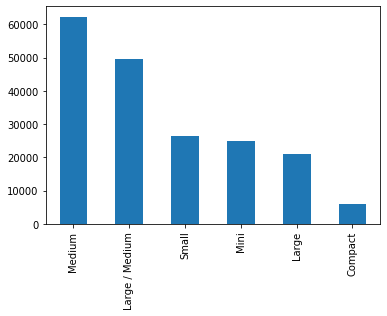

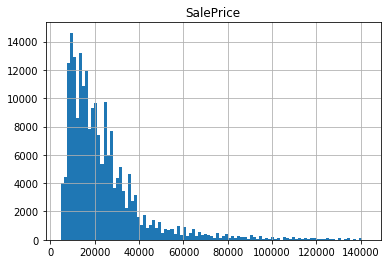

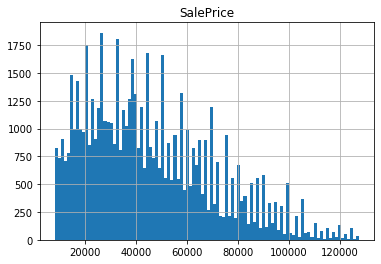

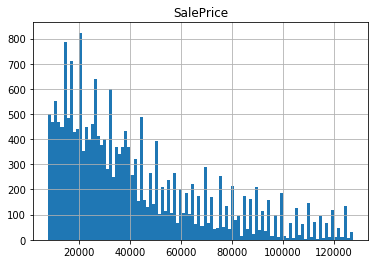

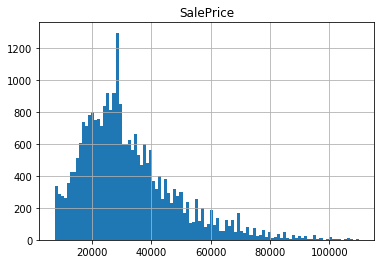

In [4]:
print('training shape',df_train.shape)
print('validation shape', df_valid.shape)
#print (df_train['Coupler_System'].unique())
print (df_train['ProductSize'].unique())

df_train['ProductSize'].value_counts().plot(kind='bar')


df_nn=df_train[df_train['ProductSize'].isnull()]
df_med=df_train[df_train['ProductSize']=='Medium']
df_large=df_train[df_train['ProductSize']=='Large']
df_small=df_train[df_train['ProductSize']=='Small']
df_lm=df_train[df_train['ProductSize']=='Large / Medium']
df_compact=df_train[df_train['ProductSize']=='Compact']


df_nn.hist(column='SalePrice',bins=100)
df_med.hist(column='SalePrice',bins=100)
df_large.hist(column='SalePrice',bins=100)
df_small.hist(column='SalePrice',bins=100)

print (df_nn.shape)

In [5]:
df_train = df_train[df_train['SalePrice'] < 110000]
print('training shape',df_train.shape)

training shape (397605, 53)


## Analysing 'Coupler_System' against 'SalePrice' to create new features (Didn't work)

32739.996814881957
26000.0
(354147, 53)
(67093, 53)
11256.263589346132
11100.0


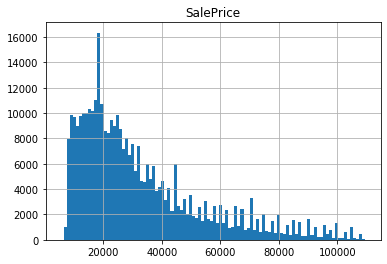

In [6]:
df_coupler=df_train[df_train['Coupler_System'].isnull()]

print (df_coupler.SalePrice.mean())
print (df_coupler.SalePrice.median())
df_coupler.hist(column='SalePrice',bins=100)
print (df_coupler.shape)
df_coupler = df_coupler[df_coupler['SalePrice'] < 15000]
print (df_coupler.shape)
print (df_coupler.SalePrice.mean())
print (df_coupler.SalePrice.median())

10470.911550828592
10000.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002248C39CCC8>]],
      dtype=object)

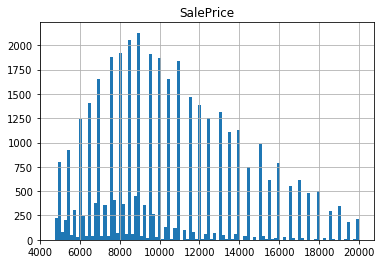

In [7]:
df_coupler=df_train[df_train['Coupler_System']=='None or Unspecified']

print (df_coupler.SalePrice.mean())
print (df_coupler.SalePrice.median())
df_coupler.hist(column='SalePrice',bins=100)

11591.859313077939
11500.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000224829CDE08>]],
      dtype=object)

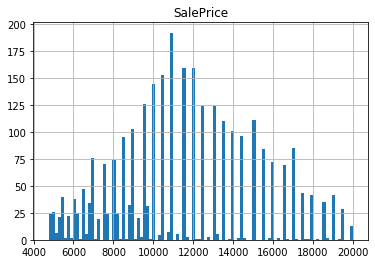

In [8]:
df_coupler=df_train[df_train['Coupler_System']=='Yes']

print (df_coupler.SalePrice.mean())
print (df_coupler.SalePrice.median())
df_coupler.hist(column='SalePrice',bins=100)

In [9]:
#converting saleprice to log scale
y = np.log(df_train['SalePrice'])
df_train = df_train.drop('SalePrice', axis=1)

In [10]:
df_train_valid = df_train.append(df_valid)

In [11]:
df_train_valid.shape

(409178, 52)

In [12]:
# same add_datepart function as used for creating baseline model
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

        
add_datepart(df_train_valid, 'saledate')

In [13]:
df_train_valid['age'] = df_train_valid['saleYear'] - df_train_valid['YearMade'] 

In [14]:
for n,c in df_train_valid.items():
    if is_string_dtype(c): 
        #print (n)
        df_train_valid[n] = c.astype('category').cat.as_ordered()

In [15]:
#Specify order for variable UsageBand and change to codes
df_train_valid.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
df_train_valid.UsageBand = df_train_valid.UsageBand.cat.codes

In [16]:
#Change other categories into codes and replace NaNs with 0.
cat_cols = list(df_train_valid.select_dtypes(include=['category']).columns)  #Above UsageType is changed to Int 
for col in cat_cols:
    s = df_train_valid[col] 
    df_train_valid[col] = s.cat.codes+1


In [17]:
#Replace the NaNs for the numerical column with mean and -1 (-1 gave better results than mean/median in auctioneerID)
df_train_valid['auctioneerID'].fillna(-1, inplace=True) 
df_train_valid['MachineHoursCurrentMeter'].fillna(df_train_valid['MachineHoursCurrentMeter'].median(), inplace=True)

In [18]:
df_train_valid.isnull().sum()

SalesID                     0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Turbocharged                0
Blade_Extension             0
Blade_Width                 0
Enclosure_Type              0
Engine_Horsepower           0
                           ..
Tire_Size                   0
Coupler                     0
Coupler_Sy

In [19]:
df_train_valid.head()
df_train_valid.shape

(409178, 65)

###  One hot encoding the ProductSize feature didn't improved th RMSLE score

In [20]:
#df_ps = pd.get_dummies(df_train_valid['ProductSize'], prefix = 'PS')

In [21]:
#df_ps.shape
#df_train_valid = pd.concat([df_train_valid, df_ps], axis=1)
#df_train_valid.shape

In [22]:
#df_train_valid=df_train_valid.drop(columns=['ProductSize'])


In [23]:

#labels=['age', 'ProductSize', 'fiProductClassDesc', 'ModelID', 'YearMade',
   #    'fiSecondaryDesc', 'saleElapsed', 'SalesID', 'fiBaseModel', 'Enclosure',
    #   'saleDayofyear', 'saleDay']

#df_train_valid = df_train_valid[df_important.columns]
#df_train_valid = df_train_valid[labels]
#Separate the training and validation sets
df_valid = df_train_valid.tail(11573)
df_train = df_train_valid.head(397605)

In [24]:
print (df_valid.shape)
print (df_train.shape)

(11573, 65)
(397605, 65)


### Random Forest model using all features

In [25]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(df_train, y) 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [26]:
#Import the validation solution
solution = pd.read_csv('ValidSolution.csv', low_memory=False)
y_actual = np.log(solution.SalePrice)     

In [27]:
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

rmse(m.predict(df_valid), y_actual)

0.2467792326875891

In [28]:
#Use the feature importance to find the most important ones
feature_importance_valid = pd.DataFrame({'Feature' : df_train.columns, 'Importance' : m.feature_importances_})
feature_importance_valid.sort_values('Importance', ascending=False, inplace=True)
feature_importance_valid.head(30)

,Feature,Importance
64,age,0.133877
13,ProductSize,0.113666
37,Coupler_System,0.103921
14,fiProductClassDesc,0.085498
5,YearMade,0.074718
2,ModelID,0.059562
38,Grouser_Tracks,0.038945
39,Hydraulics_Flow,0.038133
10,fiSecondaryDesc,0.037592
8,fiModelDesc,0.031080


In [29]:
feature_importance_valid

,Feature,Importance
64,age,1.338768e-01
13,ProductSize,1.136656e-01
37,Coupler_System,1.039214e-01
14,fiProductClassDesc,8.549777e-02
5,YearMade,7.471752e-02
2,ModelID,5.956248e-02
38,Grouser_Tracks,3.894538e-02
39,Hydraulics_Flow,3.813286e-02
10,fiSecondaryDesc,3.759197e-02
8,fiModelDesc,3.108048e-02


## Random forest using features extracted from the importance scores from baseline model (results not better from previous)

In [ ]:

#labels=['age', 'ProductSize', 'fiProductClassDesc', 'ModelID', 'YearMade',
   #    'fiSecondaryDesc', 'saleElapsed', 'SalesID', 'fiBaseModel', 'Enclosure',
    #   'saleDayofyear', 'saleDay']

df_train_valid = df_train_valid[df_important.columns]
#df_train_valid = df_train_valid[labels]
#Separate the training and validation sets
df_valid = df_train_valid.tail(11573)
df_train = df_train_valid.head(397605)

In [ ]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(df_train, y) 
print(rmse(m.predict(df_valid), y_actual))


In [ ]:
df_train_valid.shape

## Using feature importance scores from the previous model

In [31]:
for i in [0.0001, 0.0005, 0.0007, 0.0008, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.011, 0.012]:
    important_features_valid = feature_importance_valid[feature_importance_valid['Importance'] > i]
    df_train_valid_iter = df_train_valid[important_features_valid['Feature']]
    
    df_valid = df_train_valid_iter.tail(11573)
    df_train = df_train_valid_iter.head(397605)
    
    m_iter = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
    m_iter.fit(df_train, y)
    print_score(m)
    print(rmse(m_iter.predict(df_valid), y_actual))

0.24637846553662926
0.24622716746425208
0.24603803475291686
0.24631722455840918
0.24698936029774654
0.2469806853457232
0.2479935125290565
0.2494017253316464
0.24882720576457754
0.24922083625014174
0.24937985460757028
0.24956143677401707
0.2594127692579638
0.25902786772887315
0.2599710541901514
0.259243186784126


In [32]:
# we can see best RMSLE score is for 0.0007 (which were the best results we have achieved on validation set)
important_features_valid = feature_importance_valid[feature_importance_valid['Importance'] > 0.0008]

print (len(important_features_valid))
print (important_features_valid)


47
                     Feature  Importance
64                       age    0.133877
13               ProductSize    0.113666
37            Coupler_System    0.103921
14        fiProductClassDesc    0.085498
5                   YearMade    0.074718
2                    ModelID    0.059562
38            Grouser_Tracks    0.038945
39           Hydraulics_Flow    0.038133
10           fiSecondaryDesc    0.037592
8                fiModelDesc    0.031080
19                 Enclosure    0.027455
63               saleElapsed    0.026086
9                fiBaseModel    0.022627
0                    SalesID    0.021311
17          ProductGroupDesc    0.019610
16              ProductGroup    0.018857
12         fiModelDescriptor    0.016922
1                  MachineID    0.014395
51                  saleYear    0.009137
56             saleDayofyear    0.008342
30                Hydraulics    0.008150
15                     state    0.007860
54                   saleDay    0.007486
18           

In [38]:
for i in [0.0001, 0.0005, 0.0007, 0.0008, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.010, 0.011, 0.012]:
    important_features_valid = feature_importance_valid[feature_importance_valid['Importance'] > i]
    df_train_valid_iter = df_train_valid[important_features_valid['Feature']]
    
    df_valid = df_train_valid_iter.tail(11573)
    df_train = df_train_valid_iter.head(397605)
    
    m_iter = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
    m_iter.fit(df_train, y)
    
    res = [rmse(m_iter.predict(df_train), y), rmse(m_iter.predict(df_valid), y_actual),
                m_iter.score(df_train, y), m_iter.score(df_valid, y_actual), m_iter.oob_score_]
    print (res)

    print(rmse(m_iter.predict(df_valid), y_actual))

[0.07319621075330016, 0.24618098680707723, 0.9884233960829643, 0.887639550242306, 0.9153164237603247]
0.24618098680707723
[0.07326761884469297, 0.24745489004920332, 0.9884007974698317, 0.886473686995578, 0.9151911433846602]
0.24745489004920332
[0.07326922115546743, 0.2469422671941455, 0.9884002901316458, 0.8869435577152962, 0.9152231624612253]
0.2469422671941455
[0.07330916371190317, 0.24740390850230512, 0.9883876395711989, 0.8865204603759159, 0.9150508871024492]
0.24740390850230512
[0.07335446102139283, 0.24720744214435214, 0.9883732847165948, 0.8867006196924038, 0.9150450723861884]
0.24720744214435214
[0.07333954839728823, 0.2466225008413807, 0.9883780115514187, 0.8872361624619338, 0.9149663957094424]
0.2466225008413807
[0.07375649352856843, 0.24848843585799674, 0.9882454908058967, 0.8855233749527986, 0.9139984581337913]
0.24848843585799668
[0.07366012806420619, 0.24840303536356403, 0.9882761861035616, 0.8856020480739579, 0.9142201116415755]
0.24840303536356403
[0.07403027066216664, 

## Controlling depth of trees to control Overfitting if any

In [39]:
df_valid = df_train_valid_iter.tail(11573)
df_train = df_train_valid_iter.head(397605)
m = RandomForestRegressor(n_jobs=-1, n_estimators=160,oob_score=True, min_samples_leaf = 5, max_features=0.5)
m.fit(df_train, y)
res = [rmse(m.predict(df_train), y), rmse(m.predict(df_valid), y_actual),
m.score(df_train, y), m.score(df_valid, y_actual), m.oob_score_]
print (res)
print(rmse(m.predict(df_valid), y_actual))



[0.15993383888144444, 0.2549958669306382, 0.9447306063417126, 0.879449022823979, 0.9042237348050424]
0.2549958669306382


In [ ]:
set_rf_samples(20000)
m = RandomForestRegressor(n_jobs=-1, n_estimators=160,oob_score=True, min_samples_leaf = 5, max_features=0.5)
m.fit(df_train, y)
res = [rmse(m.predict(df_train), y), rmse(m.predict(df_valid), y_actual),
m.score(df_train, y), m.score(df_valid, y_actual), m.oob_score_]
print (res)
print(rmse(m.predict(df_valid), y_actual))


In [41]:

from lightgbm import LGBMRegressor


## seeing the features in our best model

In [43]:
# we can see best RMSLE score is for 0.0007
important_features_valid = feature_importance_valid[feature_importance_valid['Importance'] > 0.0007]

print (len(important_features_valid))
print (important_features_valid)

47
                     Feature  Importance
64                       age    0.133877
13               ProductSize    0.113666
37            Coupler_System    0.103921
14        fiProductClassDesc    0.085498
5                   YearMade    0.074718
2                    ModelID    0.059562
38            Grouser_Tracks    0.038945
39           Hydraulics_Flow    0.038133
10           fiSecondaryDesc    0.037592
8                fiModelDesc    0.031080
19                 Enclosure    0.027455
63               saleElapsed    0.026086
9                fiBaseModel    0.022627
0                    SalesID    0.021311
17          ProductGroupDesc    0.019610
16              ProductGroup    0.018857
12         fiModelDescriptor    0.016922
1                  MachineID    0.014395
51                  saleYear    0.009137
56             saleDayofyear    0.008342
30                Hydraulics    0.008150
15                     state    0.007860
54                   saleDay    0.007486
18           

In [44]:
df_train_valid_iter = df_train_valid[important_features_valid['Feature']]
    
df_valid = df_train_valid_iter.tail(11573)
df_train = df_train_valid_iter.head(397605)

## Using LightGBM (RMLE: 0.246417)

In [45]:
model = LGBMRegressor(
    max_depth=-1,
    boosting_type='gbdt',
    n_estimators=1500,
    min_child_weight=200, 
    colsample_bytree=0.5, 
    subsample=0.5, 
    eta=0.3,    
    seed=42)

model.fit(
    df_train, 
    y, 
    eval_metric="rmse", 
    eval_set=[(df_train, y), (df_valid, y_actual)], 
    verbose=True,    
    early_stopping_rounds = 30
    )

[1]	training's rmse: 0.636085	training's l2: 0.404604	valid_1's rmse: 0.694373	valid_1's l2: 0.482153
Training until validation scores don't improve for 30 rounds
[2]	training's rmse: 0.603491	training's l2: 0.364201	valid_1's rmse: 0.658938	valid_1's l2: 0.4342
[3]	training's rmse: 0.565559	training's l2: 0.319857	valid_1's rmse: 0.623484	valid_1's l2: 0.388733
[4]	training's rmse: 0.542384	training's l2: 0.294181	valid_1's rmse: 0.595788	valid_1's l2: 0.354964
[5]	training's rmse: 0.515214	training's l2: 0.265446	valid_1's rmse: 0.572466	valid_1's l2: 0.327718
[6]	training's rmse: 0.492817	training's l2: 0.242868	valid_1's rmse: 0.548887	valid_1's l2: 0.301277
[7]	training's rmse: 0.469941	training's l2: 0.220845	valid_1's rmse: 0.52697	valid_1's l2: 0.277697
[8]	training's rmse: 0.453504	training's l2: 0.205666	valid_1's rmse: 0.508261	valid_1's l2: 0.258329
[9]	training's rmse: 0.43984	training's l2: 0.19346	valid_1's rmse: 0.492387	valid_1's l2: 0.242445
[10]	training's rmse: 0.42

[84]	training's rmse: 0.250482	training's l2: 0.0627414	valid_1's rmse: 0.302161	valid_1's l2: 0.0913011
[85]	training's rmse: 0.250196	training's l2: 0.0625981	valid_1's rmse: 0.301703	valid_1's l2: 0.0910245
[86]	training's rmse: 0.249777	training's l2: 0.0623888	valid_1's rmse: 0.301473	valid_1's l2: 0.0908861
[87]	training's rmse: 0.249554	training's l2: 0.0622773	valid_1's rmse: 0.301352	valid_1's l2: 0.0908133
[88]	training's rmse: 0.249261	training's l2: 0.0621313	valid_1's rmse: 0.301043	valid_1's l2: 0.0906268
[89]	training's rmse: 0.248879	training's l2: 0.0619407	valid_1's rmse: 0.300459	valid_1's l2: 0.0902756
[90]	training's rmse: 0.248547	training's l2: 0.0617758	valid_1's rmse: 0.299687	valid_1's l2: 0.0898123
[91]	training's rmse: 0.248319	training's l2: 0.0616622	valid_1's rmse: 0.299347	valid_1's l2: 0.0896084
[92]	training's rmse: 0.247954	training's l2: 0.0614811	valid_1's rmse: 0.299007	valid_1's l2: 0.0894053
[93]	training's rmse: 0.247606	training's l2: 0.0613089

[166]	training's rmse: 0.233129	training's l2: 0.0543491	valid_1's rmse: 0.279202	valid_1's l2: 0.0779537
[167]	training's rmse: 0.232995	training's l2: 0.0542868	valid_1's rmse: 0.279173	valid_1's l2: 0.0779378
[168]	training's rmse: 0.232866	training's l2: 0.0542264	valid_1's rmse: 0.279075	valid_1's l2: 0.0778828
[169]	training's rmse: 0.232687	training's l2: 0.0541435	valid_1's rmse: 0.278686	valid_1's l2: 0.0776656
[170]	training's rmse: 0.232611	training's l2: 0.0541077	valid_1's rmse: 0.278478	valid_1's l2: 0.0775502
[171]	training's rmse: 0.232437	training's l2: 0.054027	valid_1's rmse: 0.278324	valid_1's l2: 0.077464
[172]	training's rmse: 0.232203	training's l2: 0.0539184	valid_1's rmse: 0.278059	valid_1's l2: 0.0773166
[173]	training's rmse: 0.232059	training's l2: 0.0538514	valid_1's rmse: 0.277803	valid_1's l2: 0.0771746
[174]	training's rmse: 0.23184	training's l2: 0.0537499	valid_1's rmse: 0.277509	valid_1's l2: 0.0770112
[175]	training's rmse: 0.231755	training's l2: 0.

[248]	training's rmse: 0.225097	training's l2: 0.0506686	valid_1's rmse: 0.267462	valid_1's l2: 0.071536
[249]	training's rmse: 0.225054	training's l2: 0.0506493	valid_1's rmse: 0.267416	valid_1's l2: 0.0715114
[250]	training's rmse: 0.224997	training's l2: 0.0506236	valid_1's rmse: 0.267354	valid_1's l2: 0.0714779
[251]	training's rmse: 0.224917	training's l2: 0.0505876	valid_1's rmse: 0.267316	valid_1's l2: 0.0714579
[252]	training's rmse: 0.224838	training's l2: 0.0505521	valid_1's rmse: 0.267304	valid_1's l2: 0.0714512
[253]	training's rmse: 0.224779	training's l2: 0.0505255	valid_1's rmse: 0.267252	valid_1's l2: 0.0714235
[254]	training's rmse: 0.224687	training's l2: 0.0504844	valid_1's rmse: 0.267184	valid_1's l2: 0.0713874
[255]	training's rmse: 0.224639	training's l2: 0.0504625	valid_1's rmse: 0.26675	valid_1's l2: 0.0711556
[256]	training's rmse: 0.224581	training's l2: 0.0504368	valid_1's rmse: 0.266669	valid_1's l2: 0.0711122
[257]	training's rmse: 0.224417	training's l2: 0

[329]	training's rmse: 0.219929	training's l2: 0.0483687	valid_1's rmse: 0.261684	valid_1's l2: 0.0684784
[330]	training's rmse: 0.219866	training's l2: 0.0483411	valid_1's rmse: 0.261667	valid_1's l2: 0.0684698
[331]	training's rmse: 0.21978	training's l2: 0.0483033	valid_1's rmse: 0.26153	valid_1's l2: 0.0683981
[332]	training's rmse: 0.219729	training's l2: 0.0482809	valid_1's rmse: 0.261432	valid_1's l2: 0.0683469
[333]	training's rmse: 0.219704	training's l2: 0.0482699	valid_1's rmse: 0.261427	valid_1's l2: 0.068344
[334]	training's rmse: 0.219647	training's l2: 0.0482447	valid_1's rmse: 0.261235	valid_1's l2: 0.0682437
[335]	training's rmse: 0.219611	training's l2: 0.0482288	valid_1's rmse: 0.2612	valid_1's l2: 0.0682255
[336]	training's rmse: 0.219516	training's l2: 0.0481874	valid_1's rmse: 0.261026	valid_1's l2: 0.0681346
[337]	training's rmse: 0.219492	training's l2: 0.0481767	valid_1's rmse: 0.261028	valid_1's l2: 0.0681355
[338]	training's rmse: 0.219442	training's l2: 0.04

[411]	training's rmse: 0.216309	training's l2: 0.0467894	valid_1's rmse: 0.257401	valid_1's l2: 0.0662554
[412]	training's rmse: 0.216271	training's l2: 0.046773	valid_1's rmse: 0.257294	valid_1's l2: 0.0662002
[413]	training's rmse: 0.216228	training's l2: 0.0467545	valid_1's rmse: 0.257276	valid_1's l2: 0.0661911
[414]	training's rmse: 0.216202	training's l2: 0.0467435	valid_1's rmse: 0.257264	valid_1's l2: 0.066185
[415]	training's rmse: 0.21618	training's l2: 0.0467337	valid_1's rmse: 0.257225	valid_1's l2: 0.0661648
[416]	training's rmse: 0.216153	training's l2: 0.0467221	valid_1's rmse: 0.257226	valid_1's l2: 0.0661652
[417]	training's rmse: 0.216134	training's l2: 0.0467138	valid_1's rmse: 0.257194	valid_1's l2: 0.0661486
[418]	training's rmse: 0.216085	training's l2: 0.0466929	valid_1's rmse: 0.257209	valid_1's l2: 0.0661566
[419]	training's rmse: 0.216039	training's l2: 0.0466729	valid_1's rmse: 0.257188	valid_1's l2: 0.0661455
[420]	training's rmse: 0.215979	training's l2: 0.

[491]	training's rmse: 0.213272	training's l2: 0.0454851	valid_1's rmse: 0.25485	valid_1's l2: 0.0649486
[492]	training's rmse: 0.213236	training's l2: 0.0454695	valid_1's rmse: 0.254774	valid_1's l2: 0.0649095
[493]	training's rmse: 0.21319	training's l2: 0.0454502	valid_1's rmse: 0.254721	valid_1's l2: 0.0648826
[494]	training's rmse: 0.213135	training's l2: 0.0454264	valid_1's rmse: 0.254595	valid_1's l2: 0.0648184
[495]	training's rmse: 0.213112	training's l2: 0.0454169	valid_1's rmse: 0.254611	valid_1's l2: 0.0648269
[496]	training's rmse: 0.213054	training's l2: 0.045392	valid_1's rmse: 0.254468	valid_1's l2: 0.064754
[497]	training's rmse: 0.213021	training's l2: 0.0453782	valid_1's rmse: 0.254461	valid_1's l2: 0.0647502
[498]	training's rmse: 0.212984	training's l2: 0.045362	valid_1's rmse: 0.254431	valid_1's l2: 0.0647353
[499]	training's rmse: 0.212942	training's l2: 0.0453442	valid_1's rmse: 0.254351	valid_1's l2: 0.0646944
[500]	training's rmse: 0.212919	training's l2: 0.04

[646]	training's rmse: 0.208493	training's l2: 0.0434692	valid_1's rmse: 0.250687	valid_1's l2: 0.062844
[647]	training's rmse: 0.20847	training's l2: 0.0434596	valid_1's rmse: 0.250665	valid_1's l2: 0.062833
[648]	training's rmse: 0.208454	training's l2: 0.043453	valid_1's rmse: 0.25065	valid_1's l2: 0.0628256
[649]	training's rmse: 0.208425	training's l2: 0.0434408	valid_1's rmse: 0.25058	valid_1's l2: 0.0627901
[650]	training's rmse: 0.208406	training's l2: 0.0434329	valid_1's rmse: 0.250572	valid_1's l2: 0.0627864
[651]	training's rmse: 0.208379	training's l2: 0.043422	valid_1's rmse: 0.250549	valid_1's l2: 0.0627746
[652]	training's rmse: 0.208339	training's l2: 0.043405	valid_1's rmse: 0.25055	valid_1's l2: 0.0627755
[653]	training's rmse: 0.208319	training's l2: 0.0433967	valid_1's rmse: 0.250515	valid_1's l2: 0.0627579
[654]	training's rmse: 0.208294	training's l2: 0.0433863	valid_1's rmse: 0.250433	valid_1's l2: 0.0627168
[655]	training's rmse: 0.208277	training's l2: 0.043379

[806]	training's rmse: 0.20478	training's l2: 0.041935	valid_1's rmse: 0.248474	valid_1's l2: 0.0617395
[807]	training's rmse: 0.20474	training's l2: 0.0419186	valid_1's rmse: 0.248385	valid_1's l2: 0.0616953
[808]	training's rmse: 0.204724	training's l2: 0.041912	valid_1's rmse: 0.248364	valid_1's l2: 0.0616849
[809]	training's rmse: 0.204716	training's l2: 0.0419085	valid_1's rmse: 0.248363	valid_1's l2: 0.061684
[810]	training's rmse: 0.204699	training's l2: 0.0419018	valid_1's rmse: 0.248326	valid_1's l2: 0.0616656
[811]	training's rmse: 0.204682	training's l2: 0.0418946	valid_1's rmse: 0.24831	valid_1's l2: 0.0616578
[812]	training's rmse: 0.20466	training's l2: 0.0418858	valid_1's rmse: 0.248232	valid_1's l2: 0.0616192
[813]	training's rmse: 0.204645	training's l2: 0.0418797	valid_1's rmse: 0.248236	valid_1's l2: 0.061621
[814]	training's rmse: 0.204629	training's l2: 0.0418732	valid_1's rmse: 0.248176	valid_1's l2: 0.0615914
[815]	training's rmse: 0.204618	training's l2: 0.04186

[889]	training's rmse: 0.203206	training's l2: 0.0412928	valid_1's rmse: 0.247424	valid_1's l2: 0.0612186
[890]	training's rmse: 0.20319	training's l2: 0.0412863	valid_1's rmse: 0.247506	valid_1's l2: 0.0612595
[891]	training's rmse: 0.203167	training's l2: 0.041277	valid_1's rmse: 0.247502	valid_1's l2: 0.0612571
[892]	training's rmse: 0.203151	training's l2: 0.0412704	valid_1's rmse: 0.247498	valid_1's l2: 0.0612551
[893]	training's rmse: 0.203125	training's l2: 0.0412599	valid_1's rmse: 0.247494	valid_1's l2: 0.0612533
[894]	training's rmse: 0.203105	training's l2: 0.0412518	valid_1's rmse: 0.247504	valid_1's l2: 0.061258
[895]	training's rmse: 0.203087	training's l2: 0.0412442	valid_1's rmse: 0.247484	valid_1's l2: 0.0612485
[896]	training's rmse: 0.203068	training's l2: 0.0412366	valid_1's rmse: 0.247495	valid_1's l2: 0.0612539
[897]	training's rmse: 0.203052	training's l2: 0.04123	valid_1's rmse: 0.247509	valid_1's l2: 0.0612608
[898]	training's rmse: 0.203038	training's l2: 0.04

[971]	training's rmse: 0.2017	training's l2: 0.0406827	valid_1's rmse: 0.246639	valid_1's l2: 0.0608306
[972]	training's rmse: 0.201663	training's l2: 0.040668	valid_1's rmse: 0.246585	valid_1's l2: 0.060804
[973]	training's rmse: 0.201644	training's l2: 0.0406604	valid_1's rmse: 0.246594	valid_1's l2: 0.0608084
[974]	training's rmse: 0.201619	training's l2: 0.0406503	valid_1's rmse: 0.246576	valid_1's l2: 0.0607995
[975]	training's rmse: 0.2016	training's l2: 0.0406424	valid_1's rmse: 0.246563	valid_1's l2: 0.0607932
[976]	training's rmse: 0.201586	training's l2: 0.0406369	valid_1's rmse: 0.246558	valid_1's l2: 0.0607909
[977]	training's rmse: 0.201565	training's l2: 0.0406284	valid_1's rmse: 0.24656	valid_1's l2: 0.0607919
[978]	training's rmse: 0.201547	training's l2: 0.0406213	valid_1's rmse: 0.246555	valid_1's l2: 0.0607895
[979]	training's rmse: 0.201525	training's l2: 0.0406122	valid_1's rmse: 0.246567	valid_1's l2: 0.0607953
[980]	training's rmse: 0.201501	training's l2: 0.0406

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
              eta=0.3, importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=200, min_split_gain=0.0,
              n_estimators=1500, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=42,
              silent=True, subsample=0.5, subsample_for_bin=200000,
              subsample_freq=0)

## Future Improvements

    (1) Use clustering/dendograms based techniques for redundant feature removal
    (2) Hyperparameter tuning in LGBM and XGBoost regressors
    (3) Selecting and clubbing two or more features
    (4) Use binning for relevant feature
    (5) Try to make more hand features
    (6) Impute the nan missing values with some other values than mean or median
    (7) Better Visualisations of dataset and results